Temporarily deprecated, notebook testing runs migrated to google cloud environment for extra compute support

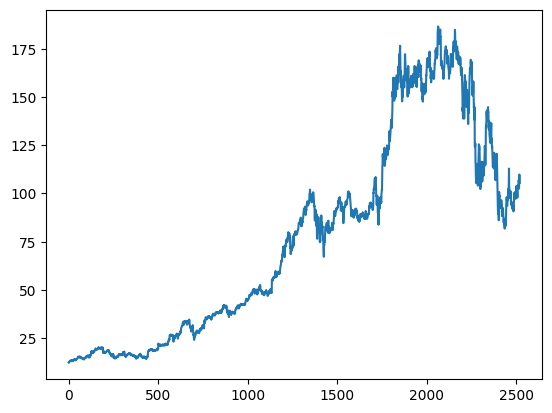

dataframe shape = (2519, 10)
0      2013-04-29
1      2013-04-30
2      2013-05-01
3      2013-05-02
4      2013-05-03
          ...    
2514   2023-04-24
2515   2023-04-25
2516   2023-04-26
2517   2023-04-27
2518   2023-04-28
Name: date, Length: 2519, dtype: datetime64[ns]


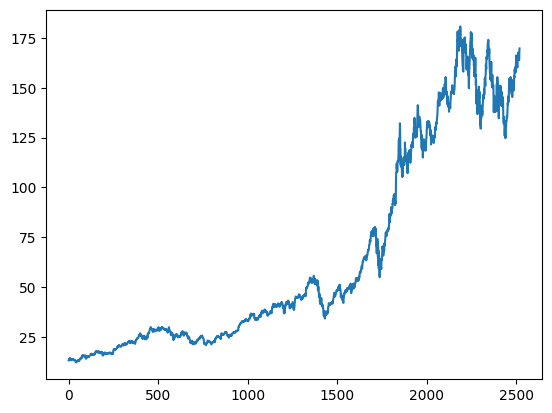

dataframe shape = (2519, 10)
0      2013-04-29
1      2013-04-30
2      2013-05-01
3      2013-05-02
4      2013-05-03
          ...    
2514   2023-04-24
2515   2023-04-25
2516   2023-04-26
2517   2023-04-27
2518   2023-04-28
Name: date, Length: 2519, dtype: datetime64[ns]


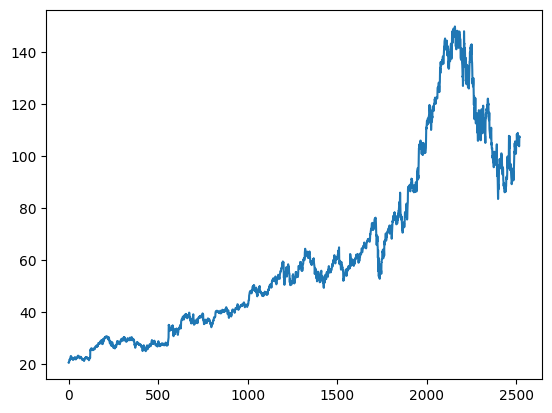

dataframe shape = (2519, 10)
0      2013-04-29
1      2013-04-30
2      2013-05-01
3      2013-05-02
4      2013-05-03
          ...    
2514   2023-04-24
2515   2023-04-25
2516   2023-04-26
2517   2023-04-27
2518   2023-04-28
Name: date, Length: 2519, dtype: datetime64[ns]


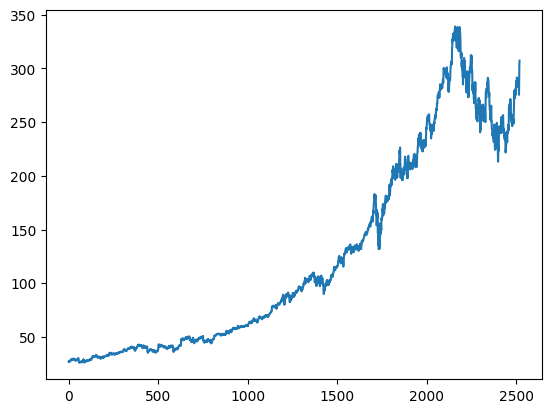

dataframe shape = (2519, 10)
0      2013-04-29
1      2013-04-30
2      2013-05-01
3      2013-05-02
4      2013-05-03
          ...    
2514   2023-04-24
2515   2023-04-25
2516   2023-04-26
2517   2023-04-27
2518   2023-04-28
Name: date, Length: 2519, dtype: datetime64[ns]


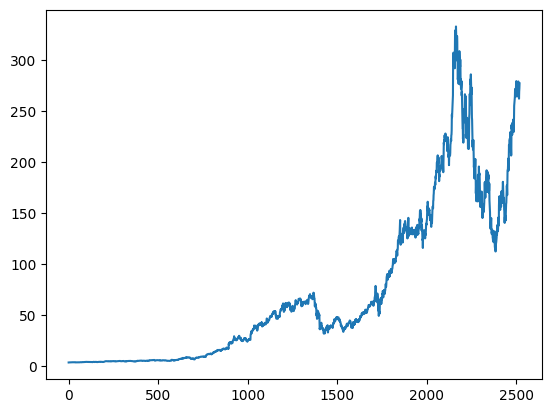

dataframe shape = (2519, 10)
0      2013-04-29
1      2013-04-30
2      2013-05-01
3      2013-05-02
4      2013-05-03
          ...    
2514   2023-04-24
2515   2023-04-25
2516   2023-04-26
2517   2023-04-27
2518   2023-04-28
Name: date, Length: 2519, dtype: datetime64[ns]


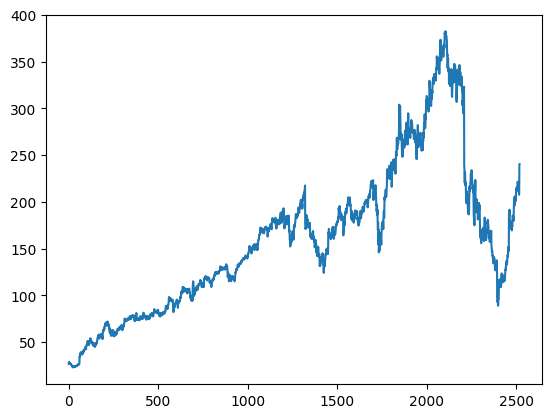

dataframe shape = (2519, 10)
0      2013-04-29
1      2013-04-30
2      2013-05-01
3      2013-05-02
4      2013-05-03
          ...    
2514   2023-04-24
2515   2023-04-25
2516   2023-04-26
2517   2023-04-27
2518   2023-04-28
Name: date, Length: 2519, dtype: datetime64[ns]


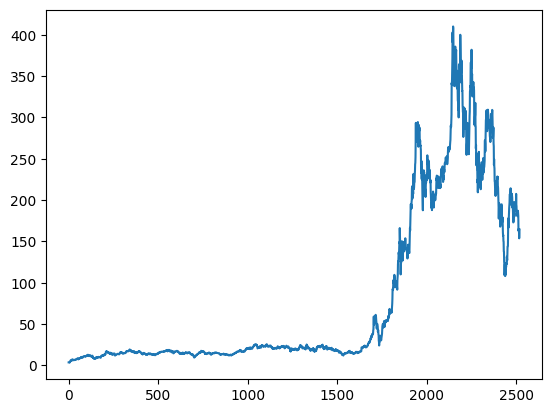

dataframe shape = (2519, 10)
0      2013-04-29
1      2013-04-30
2      2013-05-01
3      2013-05-02
4      2013-05-03
          ...    
2514   2023-04-24
2515   2023-04-25
2516   2023-04-26
2517   2023-04-27
2518   2023-04-28
Name: date, Length: 2519, dtype: datetime64[ns]


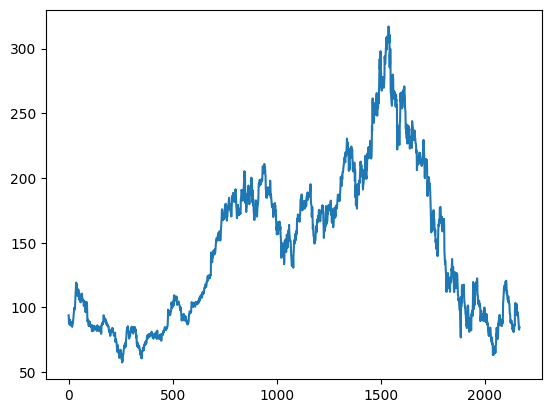

dataframe shape = (2167, 10)
0      2014-09-19
1      2014-09-22
2      2014-09-23
3      2014-09-24
4      2014-09-25
          ...    
2162   2023-04-24
2163   2023-04-25
2164   2023-04-26
2165   2023-04-27
2166   2023-04-28
Name: date, Length: 2167, dtype: datetime64[ns]


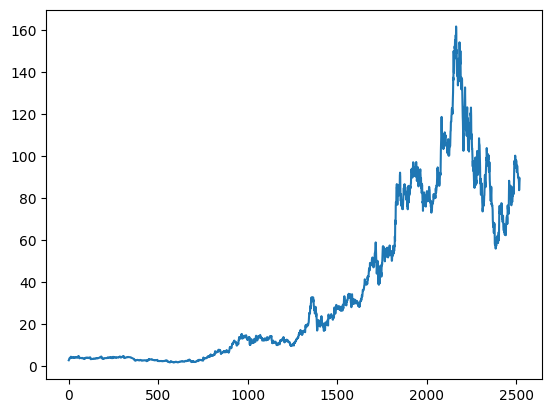

dataframe shape = (2519, 10)
0      2013-04-29
1      2013-04-30
2      2013-05-01
3      2013-05-02
4      2013-05-03
          ...    
2514   2023-04-24
2515   2023-04-25
2516   2023-04-26
2517   2023-04-27
2518   2023-04-28
Name: date, Length: 2519, dtype: datetime64[ns]


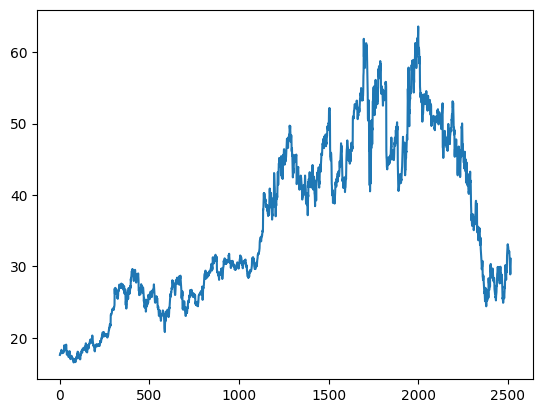

dataframe shape = (2519, 10)
0      2013-04-29
1      2013-04-30
2      2013-05-01
3      2013-05-02
4      2013-05-03
          ...    
2514   2023-04-24
2515   2023-04-25
2516   2023-04-26
2517   2023-04-27
2518   2023-04-28
Name: date, Length: 2519, dtype: datetime64[ns]


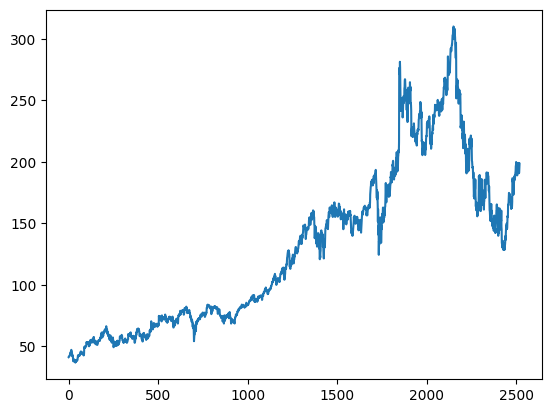

dataframe shape = (2519, 10)
0      2013-04-29
1      2013-04-30
2      2013-05-01
3      2013-05-02
4      2013-05-03
          ...    
2514   2023-04-24
2515   2023-04-25
2516   2023-04-26
2517   2023-04-27
2518   2023-04-28
Name: date, Length: 2519, dtype: datetime64[ns]
            date        Open        High         Low       Close     Volume   
0     2013-04-29   12.745000   12.850500   12.457500   12.487000  142340000  \
1     2013-04-30   12.468500   12.734000   12.428000   12.690500   84976000   
2     2013-05-01   12.695000   12.710000   12.287500   12.411500   87828000   
3     2013-05-02   12.447000   12.646500   12.289000   12.627500   78724000   
4     2013-05-03   12.807000   12.962500   12.735000   12.902500   70280000   
...          ...         ...         ...         ...         ...        ...   
27352 2023-04-24  198.449997  198.770004  194.059998  194.919998    4449700   
27353 2023-04-25  193.970001  194.119995  190.630005  190.669998    5010000   
27354 2023-04-

In [3]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

ticker_list_tech = [
    "AMZN", 
    "AAPL", 
    "GOOGL", 
    "MSFT", 
    "NVDA", 
    "META", 
    "TSLA", 
    "AMD", 
    "INTC", 
    "CRM",    
    "SOFI",
    "PYPL",
    "SNOW",
    "ADBE",
    "UBER",
    "ABNB",
    "FUBO",
    "AVGO",
    "ORCL",
    "ASML",
    "CSCO",
    "ACN",
]

ticker_list_energy = [
    "XOM",
    "CVX",
    "SHEL",
    "TTE",
    "COP",
    "BP",
    "EQNR",
    "ENB",
]


ticker_list_market_index = [
    "^NDX", 
    "^GSPC", 
    "^DJI",
    "^RUT",
    "^IXIC",
    
]

ticker_list_financial_services = [
    "BRK-A",
    "BRK-B",
    "V",
    "JPM",
    "MA",
    "BAC",
    "WFC",
    "MS",
    "HSBC",
]
ticker_lists = {
    "tech":ticker_list_tech, 
    "index":ticker_list_market_index, 
    "financial":ticker_list_financial_services,
    "energy":ticker_list_energy,
}

data_frames = []

for key, value in ticker_lists.items():
    for i in value:
        yf_df = yf.Ticker(i)
        data_hist = yf_df.history(period="10y")
        data_hist.index.name = "Date"
        data_hist = data_hist.reset_index().rename(columns={'Date': 'date'})
        data_hist = data_hist.reset_index(drop=True)
        data_hist["date"] = pd.DatetimeIndex(data_hist["date"]).strftime('%Y-%m-%d')
        data_hist = data_hist.reset_index(drop=True)
        data_hist["date"] = pd.to_datetime(data_hist["date"])
        data_hist["ticker"] = i
        data_hist["industry"] = key
        plt.plot(data_hist["date"], data_hist["Close"])
        data_frames.append(data_hist)
   

data_df = pd.concat(data_frames, ignore_index=True)
print(data_df)

In [4]:
import datetime
import json
import logging
import os
import pickle
import warnings
from typing import Optional, Union
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import torch
from pytorch_forecasting.data import TimeSeriesDataSet
from pytorch_forecasting.data.encoders import (
    EncoderNormalizer,
    GroupNormalizer,
    MultiNormalizer,
    NaNLabelEncoder,
)
from pytorch_forecasting.metrics import MultiLoss, QuantileLoss
from pytorch_forecasting.models import Baseline, TemporalFusionTransformer
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import (
    optimize_hyperparameters,
)
from pytorch_lightning import seed_everything, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
seed_everything(42)
logging.getLogger().setLevel(level=logging.INFO)
logger = logging.getLogger("edf")
logger.setLevel(level=logging.INFO)

EDFConfig = {
        "resource": "Closing Price",
        "smoothing_function": None,
        "window_size": 30,
        "training_start_ds": "2013-05-06",
        "training_end_ds": "2023-05-05",
        "forecast_start_ds": "2023-05-08",
        "forecast_end_ds": "2023-05-12",
        # "training_start_ds": "2021-01-01",
        # "training_end_ds": "2022-12-31",
        # "forecast_start_ds": "2023-01-01",
        # "forecast_end_ds": "2023-03-30",
        # "root_path": "./",
        "model_params": {
            "n_jobs": 8,
            "sort_columns": ["industry"],
            "group_columns": ["ticker"],
            "gradient_clip_val": 0.1,
            "dropout": 0.24,
            "batch_size": 64,
            "hidden_size": 24,
            "hidden_continuous_size": 12,
            "attention_head_size": 2,
            "learning_rate": 0.000646,
            "max_encoder_length": 365,
            "min_encoder_length": 30,
            "lstm_layers": 2,
            "root_path": "root_folder",
            "checkpoint_params": {
                "save_top_k": 1,
                "mode": "min",
            },
            "static_categoricals": [],  # namespace, scope
            "trainer_params": {
                "max_epochs": 2,
                "devices": -1,
                "auto_select_gpus": True,
                "limit_train_batches": 1.0,
                "auto_lr_find": False,
                "auto_scale_batch_size": False,
            },
        },
        "data_params": {
            "sort_columns": ["industry"],
            "group_columns": ["ticker"],
        },
        "date_features": {
            "dow": {"transform": True},
            "dom": {"transform": True},
            "doy": {"transform": True},
            "woy": {"transform": True},
            "moy": {"transform": True},
        },
        "target": {
            "value": [
                "value",
                # setup as a potential configureable field
            ],  
        },
        "ts_settings": {
            "sort_columns": ["industry"],
            "group_columns": ["ticker"],
            "time_varying_unknown_reals": [
                # "value"
            ],
            "static_reals": [
                "histogram_mode",
                "linearity",
                # "heterogeneity",
                # "entropy",
                # "spikiness",
                # "trend_mag",
                # "seasonality_mag",
            ],
            "time_varying_known_categoricals": ["quarter"], #is_weekday
            "scalers": {
                "year": StandardScaler(),
                "histogram_mode": StandardScaler(),
                "linearity": StandardScaler(),
                # "heterogeneity": StandardScaler(),
                # "entropy": StandardScaler(),
                # "spikiness": StandardScaler(),
                # "trend_mag": StandardScaler(),
                # "seasonality_mag": StandardScaler(),
            },
            "lags": {
                # "coldstorage": [1, 2, 3, 7, 14, 30, 60, 90],
                # "not_coldstorage": [1, 2, 3, 7, 14, 30, 60, 90],
                "Close": [1, 2, 3, 7, 14, 30],
            },
            "allow_missing_timesteps": True,
            "add_relative_time_idx": True,
            "add_target_scales": True,
            "add_encoder_length": True,
        },
        "tft_settings": {
            "log_interval": -1,
            "log_val_interval": -1,
            "quantile_list": [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98],
            "forecast_quantile": 0.5,
            "reduce_on_plateau_patience": 4,
            "share_single_variable_networks": False,
            "weight_decay": 0.1,
        },
        "hyperparamter_tuning": {
            "model_path": "optuna_tuning",
            "n_trials": 20,
            "max_epochs": 4,
            "gradient_clip_val_range": (0.01, 1.0),
            "hidden_size_range": (8, 128),
            "hidden_continuous_size_range": (8, 128),
            "attention_head_size_range": (1, 4),
            "learning_rate_range": (0.0001, 0.1),
            "dropout_range": (0.0, 0.3),
            "trainer_kwargs": {
                "limit_train_batches": 1.0,
                "default_root_dir": "root_folder",
                "auto_select_gpus": True,
                "enable_progress_bar": True,
                "devices": -1,
                "auto_scale_batch_size": False,
            },
            "reduce_on_plateau_patience": 4,
            "use_learning_rate_finder": True,
        },
    }

config = EDFConfig

c:\Users\willb\Downloads\janus\forecastingenv\lib\site-packages\pytorch_forecasting\models\base_model.py:30: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Global seed set to 42


In [5]:
class EDF:
    def __init__(self, config: EDFConfig, debug: Optional[bool] = False):
        self.logger = logger
        self.config: EDFConfig = config
        # Training and forecast date references
        self.train_start: pd.Timestamp = pd.to_datetime(config["training_start_ds"])
        self.train_end: pd.Timestamp = pd.to_datetime(config["training_end_ds"])
        self.forecast_start: pd.Timestamp = pd.to_datetime(config["forecast_start_ds"])
        self.forecast_end: pd.Timestamp = pd.to_datetime(config["forecast_end_ds"])
        self.future_forecast: bool = bool(self.forecast_end > pd.to_datetime("today"))
        self.train_dataloader = None
        self.val_dataloader = None
        self.model_path: str = None
        self.model = None
        self.trainer = None
        # Data definitions
        self.data_df: pd.DataFrame = None
        self.training_df: pd.DataFrame = None
        self.holdout_df: pd.DataFrame = None
        self.forecast_df: pd.DataFrame = None
        self.metric_df: pd.DataFrame = None
        # Class behavior setup
        self.debug = debug
        if debug:
            self.logger.setLevel(level=logging.DEBUG)
        # Target data definition
        self.target_set: list = ["Close"]

    # Need to update for yfinance dataset fetch
    def fetcher(self):
        self.fetcher = Fetcher(config=self.config, debug=self.debug)
        return self.fetcher

    def process_data(self, data):
        pass

    # function for transforming date features if configured
    def date_tfs(
        self,
        df: pd.DataFrame,
        date_agg: str,
        tf: str,
        time_varying_known_reals: list,
    ):
        if date_agg == "dow":
            df[date_agg] = df["date"].dt.dayofweek
            divisor = 7
        elif date_agg == "dom":
            df[date_agg] = df["date"].dt.day
            divisor = 30.5
        elif date_agg == "doy":
            df[date_agg] = df["date"].dt.dayofyear
            divisor = 365.25
        elif date_agg == "woy":
            df[date_agg] = df["date"].dt.week
            divisor = 52
        elif date_agg == "moy":
            df[date_agg] = df["date"].dt.month
            divisor = 12
        if tf == True:
            df[date_agg + "_sin"] = np.sin(2 * np.pi * df[date_agg] / divisor)
            df[date_agg + "_cos"] = np.cos(2 * np.pi * df[date_agg] / divisor)
            # Drop the standard version
            df = df.drop(columns=[date_agg])
            # Add column names to tvkr list
            time_varying_known_reals.append(date_agg + "_sin")
            time_varying_known_reals.append(date_agg + "_cos")
        else:
            # If untransformed then just use regular date feature name
            time_varying_known_reals.append(date_agg)
        return df, time_varying_known_reals

    def load_data(self, data_df: pd.DataFrame):
        # Ensure that we have data in our training DataFrame
        assert data_df.shape[0] > 0
        # TODO: most basic data cleaning in another fn
        data_df["date"] = pd.to_datetime(data_df["date"])
        # Split raw data into training and holdout periods
        self.training_df = data_df.loc[
            (data_df["date"] >= self.train_start) & (data_df["date"] <= self.train_end)
        ]
        self.holdout_df = data_df.loc[
            (data_df["date"] >= self.forecast_start)
            & (data_df["date"] <= self.forecast_end)
        ]
        # Ensure that we have data in our training DataFrame
        assert self.training_df.shape[0] > 0
        if self.holdout_df.empty and not self.future_forecast:
            raise ValueError("Not a future forecast and holdout_df contains no data.")
        self.data_df = data_df
        return self.data_df

    def data_setup(
        self, data: Optional[pd.DataFrame] = pd.DataFrame, params: Optional[dict] = {}
    ) -> pd.DataFrame:
        # default_params = get_defaults("data", config=self.config)
        params = {**params}
        # default_ts_settings = get_defaults("ts_settings", config=self.config)
        ts_settings = {**(self.config["ts_settings"])}
        # default_date_features = get_defaults("date_features", config=self.config)
        date_features = {**(self.config["date_features"])}
        # Load in time series settings parameters
        params = {**params, **(self.config["ts_settings"])}
        # Converting to str in order to output all values without error
        output_dict = str(params)
        print(output_dict)
        self.logger.info(
            f"Preparing data for model with parameters {json.dumps(output_dict, indent=2)}"
        )
        # Decide which data to prepare, passed in or training data on the class
        if not data.empty:
            self.logger.info("Preparing data that was passed in to data_setup().")
            data_df = data.copy()
        else:
            assert self.data_df is not None and not self.data_df.empty
            self.logger.info(
                "No data passed in, running data_setup() on the class' data_df."
            )
            data_df = self.data_df.copy()
        # Save a copy of the data before applying any processing
        self.raw_df = data_df.copy()
        # TODO: move to different function
        time_varying_unknown_reals = ts_settings.get("time_varying_unknown_reals")
        target_cols = self.target_set
        data_df["value"] = np.sum([data_df[target] for target in target_cols], axis=0)
        print(data_df.describe())
        print(data_df.dtypes)
        if "task_tier_avg" in time_varying_unknown_reals:
            data_df["task_tier_avg"] = data_df["task_tier_avg"].fillna(4)
        if "engine_proportion" in time_varying_unknown_reals:
            data_df["engine_proportion"] = data_df["engine_proportion"].astype(float)
            data_df["engine_proportion"] = data_df["engine_proportion"].fillna(0.5)
        # Take rolling average of the target
        window_size = params.get("window_size")

        def rolling_avg_fn(x):
            return x.rolling(window=window_size).mean()

        def rolling_max_fn(x):
            return x.rolling(window=window_size).max()

        if params.get("smoothing_function") == "mean":
            smoothing_function = rolling_avg_fn
        elif params.get("smoothing_function") == "max":
            smoothing_function = rolling_max_fn
        if params.get("smoothing_function"):
            data_df["value"] = (
                data_df.sort_values(by=params["sort_columns"])
                .groupby(params["group_columns"])[["value"]]
                .apply(smoothing_function)
            )
        # Add date features
        self.logger.info("Preparing data with configured date features.")
        # incoming value column data contains NAN's, this is a temp fix
        data_df["value"] = data_df["value"].fillna(0.0)
        time_varying_known_reals = ["year"]

        for date_agg, tf in date_features.items():
            transform = tf.get("transform")
            data_df, time_varying_known_reals = self.date_tfs(
                df=data_df,
                date_agg=date_agg,
                tf=transform,
                time_varying_known_reals=time_varying_known_reals,
            )
        self.logger.info("Preparing data with regular date features.")
        # Add categorical date features
        data_df["quarter"] = data_df["date"].dt.quarter
        data_df["quarter"] = data_df["quarter"].astype(str)
        data_df["is_weekday"] = data_df["date"].dt.dayofweek.apply(
            lambda x: "no" if x in (5, 6) else "yes"
        )
        data_df["year"] = data_df["date"].dt.year
        # Limit data to series with more than x days of history and has recent data
        min_series_len = params.get("min_series_len")
        max_date = data_df["date"].max()
        
        """ Deprecating this function for now, current state is breaking as it returns a series with
        the date column as the index so we see a merge error as there are no similar columns betwenn
        max_data and data_df"""

#         def get_weekly_max(series_data):
#             series_data.set_index("date", inplace=True)
#             weekly_max = series_data.resample("W").max()
#             weekly_max = (
#                 weekly_max.reindex(index=series_data.index)
#                 .fillna(method="bfill")
#                 .fillna(method="ffill")
#             )
#             weekly_max = weekly_max.rename(columns={"value": "weekly_max"})
#             return weekly_max

#         # Calculate weekly max variable
#         max_data = (
#             data_df.sort_values(by=params["sort_columns"])
#             .groupby(params["group_columns"])
#             .apply(lambda x: get_weekly_max(x[["date", "value"]]))
#         )
#         print(max_data)

        # Join everything together, start with ns-scope unique data
        data_df = data_df.set_index(params["group_columns"])
        data_df = data_df.reset_index()
        # Merge data with ns-scope-date unique data
        data_df = data_df.set_index(params["sort_columns"])
        
        # Commented out while weekly max is deprecated
        # data_df = data_df.merge(max_data, left_index=True, right_index=True)
        data_df = data_df.reset_index()
        data_df = data_df.replace([np.inf, -np.inf], np.nan)
        # Fill in null prod and adhoc values with 0 if compute calc
        # if self.config["resource"] == "Warehouse Compute":
        for ind, target in enumerate(self.target_set):
            data_df[target] = data_df[target].fillna(0)
        data_df = data_df.dropna()
        self.logger.info("Finished preparing the data for model.")
        return data_df, time_varying_known_reals

    def model_setup(
        self, data_df: pd.DataFrame, time_varying_known_reals: list, params: dict = {}
    ):
        # default_params = get_defaults("model", config=self.config)
        model_params = {**self.config["model_params"]}
        print(model_params)
        data_df["time_idx"] = data_df.apply(
            lambda x: x["date"].year * 365
            + ((x["date"] - datetime.datetime(x["date"].year, 1, 1)).days + 1),
            axis=1,
        )
        data_df["time_idx"] -= data_df["time_idx"].min()
        # Forecast params
        max_prediction_length = (self.forecast_end - self.forecast_start).days + 1
        # Train and holdout data split
        self.training_df = data_df[lambda x: x["date"] <= self.train_end]
        if not self.future_forecast:
            self.holdout_df = data_df[lambda x: x["date"] >= self.forecast_start]
            # List of training included group combos
            included = self.training_df.apply(
                lambda x: " ".join([x[col] for col in model_params["group_columns"]]),
                axis=1,
            ).values
            data_df["ticker"].loc[
                ~data_df.apply(
                    lambda x: " ".join(
                        [x[col] for col in model_params["group_columns"]]
                    ),
                    axis=1,
                ).isin(included),
            ] = "None"
        # Define dataset
        self.logger.info(f"Defining model to forecast {max_prediction_length} days.")
        # default_ts_settings = get_defaults("ts_settings", config=self.config)
        ts_settings = {**self.config["ts_settings"]}
        print(ts_settings)
        # default_tft_settings = get_defaults("tft_settings", config=self.config)
        tft_settings = {**self.config["tft_settings"]}
        # Pytorch is finnicky with lists vs single values being passed in
        # This handles those intricacies, leaving single values when needed
        if len(self.target_set) > 1:
            target_values = self.target_set
            target_normalizer = MultiNormalizer(
                normalizers=[
                    GroupNormalizer(
                        groups=model_params["group_columns"],
                        transformation="softplus",
                    )
                    for x in self.target_set
                ]
            )
            loss = MultiLoss(
                [
                    QuantileLoss(quantiles=(tft_settings.get("quantile_list")))
                    for x in self.target_set
                ]
            )
            output_size = [
                len(tft_settings.get("quantile_list")) for x in self.target_set
            ]
        else:
            target_values = self.target_set[0]
            target_normalizer = GroupNormalizer(
                groups=model_params["group_columns"],
                transformation="softplus",
            )  #scale_by_group argument to be true? (defaults to false)
            loss = QuantileLoss(quantiles=(tft_settings.get("quantile_list")))
            output_size = len((tft_settings.get("quantile_list")))
        time_varying_unknown_reals = ts_settings.get("time_varying_unknown_reals")
        categorical_encoders = {}
        for stat_cat in set(model_params.get("static_categoricals")):
            categorical_encoders[stat_cat] = NaNLabelEncoder(add_nan=True).fit(
                # This should bring in all categories
                data_df[stat_cat]
            )
        print(categorical_encoders)
        self.training = TimeSeriesDataSet(
            self.training_df,
            time_idx="time_idx",
            target=target_values,
            group_ids=model_params.get("group_columns"),
            static_categoricals=model_params.get("static_categoricals"),
            categorical_encoders=categorical_encoders,
            min_encoder_length=model_params.get("min_encoder_length"),
            max_encoder_length=model_params.get("max_encoder_length"),
            max_prediction_length=max_prediction_length,
            target_normalizer=target_normalizer,
            static_reals=[],
            time_varying_known_categoricals=ts_settings.get(
                "time_varying_known_categoricals"
            ),
            time_varying_known_reals=time_varying_known_reals,
            time_varying_unknown_reals=(self.target_set + time_varying_unknown_reals),
            scalers=ts_settings.get("scalers"),
            lags=ts_settings.get("lags"),  # issue with future forecast
            # lags can only go as far back as max_encoder_length for ff ?
            allow_missing_timesteps=ts_settings.get("allow_missing_timesteps"),
            add_relative_time_idx=ts_settings.get("add_relative_time_idx"),
            add_target_scales=ts_settings.get("add_target_scales"),
            add_encoder_length=ts_settings.get("add_encoder_length"),
        )
        # create training dataset
        
        self.train_dataloader = self.training.to_dataloader(
            train=True,
            batch_size=model_params.get("batch_size"),
            num_workers=model_params.get("n_jobs"),
            persistent_workers=True,
            )
        if not self.future_forecast:
            self.logger.info(
                "Creating a validation dataset to check against predictions."
            )
            self.validation = TimeSeriesDataSet.from_dataset(
                self.training, data_df, stop_randomization=True, predict=True
            )
            self.val_dataloader = self.validation.to_dataloader(
                train=False,
                batch_size=model_params.get("batch_size"),
                num_workers=model_params.get("n_jobs"),
                persistent_workers=True,
            )
        else:
            self.logger.info(
                "Creating a validation dataset using last 90 days of training."
            )
        self.model = TemporalFusionTransformer.from_dataset(
            self.training,
            learning_rate=model_params.get("learning_rate"),
            log_interval=-tft_settings.get("log_interval"),
            log_val_interval=tft_settings.get("log_val_interval"),
            lstm_layers=model_params.get("lstm_layers"),
            hidden_size=model_params.get("hidden_size"),
            hidden_continuous_size=model_params.get(
                "hidden_continuous_size"
            ),  # set to <= hidden_size
            output_size=output_size,  # 7 quantiles by default
            loss=loss,
            attention_head_size=model_params.get("attention_head_size"),
            dropout=model_params.get("dropout"),
            reduce_on_plateau_patience=tft_settings.get("reduce_on_plateau_patience"),
            share_single_variable_networks=tft_settings.get(
                "share_single_variable_networks"
            ),
            weight_decay=tft_settings.get("weight_decay"),
        )
        self.logger.info(
            f"Number of parameters in network: {self.model.size()/1e3:.1f}k"
        )
        self.logger.info(self.model.hparams)

    def train_model(self):
        # default_params = get_defaults("model", config=self.config)
        params = {**self.config["model_params"]}
        filename = (
            "{epoch:02d}-{val_loss:.2f}"
            if not self.future_forecast
            else "{epoch:02d}-{train_loss:.2f}"
        )
        monitor = "val_loss" if not self.future_forecast else "train_loss"
        checkpoint_params = params.get("checkpoint_params")
        checkpoint_callback = ModelCheckpoint(
            monitor=monitor,
            filename=filename,
            save_top_k=checkpoint_params.get("save_top_k"),
            mode=checkpoint_params.get("mode"),
            verbose=True,
        )
        # Device declaration is just broken. With only the accelerator arg, cpu support runs well
        # gpus variable instantiation might be necessary for cuda devices but I'm unsure
        # Define trainer
        gpus = (
            torch.cuda.device_count()
            if (torch.cuda.is_available() and torch.cuda.device_count() >= 1)
            else 0
        )
        
        num_cpus = multiprocessing.cpu_count()
        devices = num_cpus if gpus == 0 else [i for i in range(num_cpus)]
        
        trainer_params = params.get("trainer_params")
        self.logger.debug(f"Found and using {gpus} gpu in model training.")
        self.trainer = Trainer(
            max_epochs=trainer_params.get("max_epochs"),
            accelerator="gpu" if gpus else "cpu",
            # devices=devices,
            # auto_select_gpus=trainer_params.get("auto_select_gpus"),
            gradient_clip_val=params.get("gradient_clip_val"),
            limit_train_batches=trainer_params.get("limit_train_batches"),
            # auto_lr_find=trainer_params.get("auto_lr_find"),
            # auto_scale_batch_size=trainer_params.get("auto_scale_batch_size"),
            callbacks=[checkpoint_callback],
            resume_from_checkpoint=self.model_path or None,
            default_root_dir=params.get("root_path"),
        )
        try:
            if self.model_path and self.model:
                self.logger.info(
                    f"Will continue training model from checkpoint {self.model_path}"
                )
                self.trainer.fit(
                    self.model,
                    ckpt_path=self.model_path,
                    train_dataloaders=self.train_dataloader,
                    val_dataloaders=self.val_dataloader,
                )
            else:
                self.logger.info("Beginning to train new model...")
                self.trainer.fit(
                    self.model,
                    train_dataloaders=self.train_dataloader,
                    val_dataloaders=self.val_dataloader,
                )
        except KeyboardInterrupt:
            self.logger.info("Model training shopped short. Continuing.")
        print(self.train_dataloader)
        print(self.val_dataloader)
        self.logger.info("Model training complete.")

    def load_model(self, version: int, checkpoint: str) -> None:
        # default_params = get_defaults("model", config=self.config)
        params = {**self.config["model_params"], **(self.config)}
        # TODO: need to make sure model is appropriate for the given config
        checkpoint_path = os.path.join(
            params.get("root_path"), "lightning_logs/", f"version_{version}/"
        )
        self.model_path = os.path.join(checkpoint_path, "checkpoints/", checkpoint)
        self.model = TemporalFusionTransformer.load_from_checkpoint(self.model_path)
        self.logger.info(f"Loaded model from {self.model_path}.")
        self.logger.warn(
            "Loading model to continue training will create a new version."
        )

    def compare_to_baseline(self) -> None:
        if not self.val_dataloader or self.future_forecast:
            self.logger.error(
                "No validation dataloader found, unable to check prediction accuracy."
            )
            return None
        if self.trainer:
            self.model_path = self.trainer.checkpoint_callback.best_model_path
            self.logger.info(
                f"Found a Trainer, using best model path {self.model_path}."
            )
        else:
            self.logger.info(f"No trainer found, loading model from {self.model_path}.")
        model = TemporalFusionTransformer.load_from_checkpoint(self.model_path)
        self.logger.debug("Model loaded from checkpoint.")
        predictions, x = model.predict(self.val_dataloader, return_x=True)
        self.logger.debug("Holdout predictions made.")
        # calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
        for ind, target in enumerate(self.target_set):
            actuals = torch.cat([row[1][0][ind] for row in iter(self.val_dataloader)])
            baseline_predictions = Baseline().predict(self.val_dataloader)
            self.logger.info(target)
            self.logger.info(
                f"Model MAE: {(actuals - predictions[ind]).abs().mean()}"
            )  # MAE
            self.logger.info(
                f"Baseline MAE: {(actuals - baseline_predictions[ind]).abs().mean().item()}"
            )

    def predict(self):
        if self.trainer:
            self.model_path = self.trainer.checkpoint_callback.best_model_path
            self.logger.info(
                f"Found a Trainer, using best model path {self.model_path}."
            )
        else:
            self.logger.info(f"No trainer found, loading model from {self.model_path}.")
        model = TemporalFusionTransformer.load_from_checkpoint(self.model_path)
        if not self.future_forecast:
            predictions, x = model.predict(
                self.val_dataloader, mode="raw", return_x=True
            )
            series = self.validation.x_to_index(x)
        else:
            # default_params = get_defaults("model", config=self.config)
            params = {**self.config["model_params"], **(self.config)}
            max_prediction_length = (self.forecast_end - self.forecast_start).days + 1
            max_encoder_length = params.get("max_encoder_length")
            # select last [encoder_length] days from data
            encoder_data = self.training_df[
                lambda x: x.time_idx > x.time_idx.max() - max_encoder_length
            ]
            # select last known data point and create decoder data from it
            last_data = self.training_df[lambda x: x.time_idx == x.time_idx.max()]
            decoder_data = pd.concat(
                [
                    last_data.assign(date=lambda x: x.date + pd.offsets.Day(i))
                    for i in range(1, max_prediction_length + 1)
                ],
                ignore_index=True,
            )
            # Add time index consistent with encoder data
            decoder_data["time_idx"] = decoder_data.apply(
                lambda x: x["date"].year * 365
                + ((x["date"] - datetime.datetime(x["date"].year, 1, 1)).days + 1),
                axis=1,
            )
            decoder_data["time_idx"] += (
                encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()
            )
            date_features = params.get("date_features")
            time_varying_known_reals = ["year"]
            for date_agg, tf in date_features.items():
                transform = tf.get("transform")
                decoder_data, time_varying_known_reals = self.date_tfs(
                    df=decoder_data,
                    date_agg=date_agg,
                    tf=transform,
                    time_varying_known_reals=time_varying_known_reals,
                )
            # Add categorical date features
            decoder_data["quarter"] = decoder_data["date"].dt.quarter
            decoder_data["quarter"] = decoder_data["quarter"].astype(str)
            decoder_data["is_weekday"] = decoder_data["date"].dt.dayofweek.apply(
                lambda x: "no" if x in (5, 6) else "yes"
            )
            decoder_data["year"] = decoder_data["date"].dt.year
            # Clear to-be-predicted data
            ts_settings = params.get("ts_settings")
            time_varying_unknown_reals = ts_settings.get("time_varying_unknown_reals")
            decoder_data[self.target_set] = 0
            for col in time_varying_unknown_reals:
                decoder_data[col] = 0
            # Combine encoder and decoder data
            prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)
            # data_params = get_defaults("data", self.config)
            prediction_data = prediction_data.sort_values(
                by=params.get("sort_columns")
            )
            predictions, x = model.predict(
                prediction_data, mode="raw", return_x=True
            )  # prediction
            series = self.training.x_to_index(x)
        index = pd.date_range(
            start=self.forecast_start, end=self.forecast_end, name="date"
        )
        # default_tft_settings = get_defaults("tft_settings", config=self.config)
        tft_settings = {**self.config["tft_settings"]}
        # default_data_params = get_defaults("data", self.config)
        data_params = {
            **self.config["data_params"],
        }
        all_preds = []
        # format is predictions[forecast_values][scope][day] which gets you to the quantiles
        # below 0 is forecast values, idx is scope, and ind is day
        for idx in range(len(series)):
            preds_df = pd.DataFrame()
            print(preds_df)
            
            for ind, target in enumerate(self.target_set):
                cols = [
                    f"{target}-{quantile}"
                    for quantile in tft_settings.get("quantile_list")
                ]
                # depending on number of targets passed in, the shape of predictions changes
                # if statement below handles those differences
                if len(self.target_set) > 1:
                    predictions_insert = predictions[0][ind][idx].numpy()
                else:
                    predictions_insert = predictions[0][idx].numpy()
                # format with just one target is predictions[forecast_values][scope][day]
                if preds_df.empty:
                    preds_df = pd.DataFrame(
                        predictions_insert, index=index, columns=cols
                    )
                else:
                    target_df = pd.DataFrame(
                        predictions_insert, index=index, columns=cols
                    )
                    preds_df = preds_df.merge(target_df, on="date")
            for col in data_params.get("group_columns"):
                preds_df[col] = series.iloc[idx][col]
            all_preds.append(preds_df)
        self.forecast_df = pd.concat(all_preds).reset_index()
        return self.forecast_df

    def tune_hyperparameters(self):
        if not self.train_dataloader or not self.val_dataloader:
            raise ValueError("Tuning requires a training and validation dataloader")
        logger.info("Tunining hyperparameters")
        hyperparamter_tuning_params = {
            **self.config["hyperparamter_tuning"],
        }
        # create study
        study = optimize_hyperparameters(
            self.train_dataloader,
            self.val_dataloader,
            model_path=hyperparamter_tuning_params.get("model_path"),
            n_trials=hyperparamter_tuning_params.get("n_trials"),
            max_epochs=hyperparamter_tuning_params.get("max_epochs"),
            gradient_clip_val_range=hyperparamter_tuning_params.get(
                "gradient_clip_val_range"
            ),
            hidden_size_range=hyperparamter_tuning_params.get("hidden_size_range"),
            hidden_continuous_size_range=hyperparamter_tuning_params.get(
                "hidden_continuous_size_range"
            ),
            attention_head_size_range=hyperparamter_tuning_params.get(
                "attention_head_size_range"
            ),
            learning_rate_range=hyperparamter_tuning_params.get("learning_rate_range"),
            dropout_range=hyperparamter_tuning_params.get("dropout_range"),
            trainer_kwargs=hyperparamter_tuning_params.get("trainer_kwargs"),
            reduce_on_plateau_patience=hyperparamter_tuning_params.get(
                "reduce_on_plateau_patience"
            ),
            use_learning_rate_finder=hyperparamter_tuning_params.get(
                "use_learning_rate_finder"
            ),
        )
        # save study results - also we can resume tuning at a later point in time
        with open("test_study.pkl", "wb") as fout:
            pickle.dump(study, fout)
        # show best hyperparameters
        print(study.best_trial.params)

    def evaluate_holdout(self):
        # validation metrics are likely going to live in another file
        pass
    def metric_summary(self):
        # validation metrics are likely going to live in another file
        pass

    def plot_holdout(self):
        # leaving this here in case vis support is easier to bake in
        def plot_function():
    
            
            pass

In [16]:
edf = EDF(config=config, debug=False)
edf.load_data(data_df=data_df)
data_df, time_varying_known_reals = edf.data_setup(data=data_df,params={})

{'sort_columns': ['industry'], 'group_columns': ['ticker'], 'time_varying_unknown_reals': [], 'static_reals': ['histogram_mode', 'linearity'], 'time_varying_known_categoricals': ['quarter', 'is_weekday'], 'scalers': {'year': StandardScaler(), 'histogram_mode': StandardScaler(), 'linearity': StandardScaler()}, 'lags': {'value': [1, 2, 3, 7, 14, 30]}, 'allow_missing_timesteps': True, 'add_relative_time_idx': True, 'add_target_scales': True, 'add_encoder_length': True}
                                date          Open          High   
count                          27357  27357.000000  27357.000000  \
mean   2018-05-17 19:55:07.862704384     88.878353     90.077912   
min              2013-04-29 00:00:00      1.620000      1.690000   
25%              2015-11-30 00:00:00     27.590669     27.908909   
50%              2018-05-21 00:00:00     60.096282     60.815383   
75%              2020-11-06 00:00:00    136.833085    139.000000   
max              2023-04-28 00:00:00    411.470001   

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
edf.model_setup(data_df=data_df, time_varying_known_reals=time_varying_known_reals)

In [ ]:
edf.train_model()

In [ ]:
#Below is the model for the 05-01-2023 through 05-06-2023
edf.load_model(version=37, checkpoint="epoch=01-train_loss=31.83.ckpt")
results_df = edf.predict()

In [ ]:
results_df
hist_df = data_df


In [ ]:
for i in ticker_list_tech:
    forecast_df = results_df.loc[results_df["ticker"] == i]
    hist_df = data_df.loc[data_df["ticker"] == i]
    hist_df = hist_df[hist_df["date"] >= pd.to_datetime("2023-01-01")]
    hist_close = hist_df.loc[hist_df["date"] == pd.Timestamp("2023-04-28"), "Close"].values[0]

    # Filter data to include only the rows where the date column is equal to 2023-05-05
    percent_diff_df = hist_df[hist_df["date"] == pd.Timestamp("2023-05-05")]

    # Get the "value-0.5" forecast value on 2023-05-01
    forecast_value = forecast_df.loc[forecast_df["date"] == pd.Timestamp("2023-05-01"), "Close-0.5"].values[0]

    # Calculate the difference
    diff = hist_close - forecast_value
    print(f"The difference between the forecast value and historical 'Close' value is: {diff:.2f}")

    forecast_df["Close-0.5"] = forecast_df["Close-0.5"] + diff
    forecast_df["Close-0.25"] = forecast_df["Close-0.25"] + diff
    forecast_df["Close-0.75"] = forecast_df["Close-0.75"] + diff

    # Calculate percent difference between historical "Close" value and forecasted value on 2023-05-01
    forecast_value_0505 = forecast_df.loc[forecast_df["date"] == pd.Timestamp("2023-05-05"), "Close-0.5"].values[0]
    hist_close_0505 = percent_diff_df.loc[percent_diff_df["date"] == pd.Timestamp("2023-05-05"), "Close"].values[0]
    percent_diff = abs((hist_close_0505 - forecast_value_0505) / hist_close_0505) * 100

    # Create card with percent difference
    card_text = f"Percent Difference on 2023-05-05\n{percent_diff:.2f}%"

    # Plot data
    plt.plot(hist_df["date"], hist_df["Close"], label=f"{i} Historical Data")
    plt.plot(forecast_df["date"], forecast_df["Close-0.5"], label=f"{i} Forecast 0.5")
    # plt.plot(forecast_df["date"], forecast_df["Close-0.75"], label=f"{i} Forecast 0.75")
    # plt.plot(forecast_df["date"], forecast_df["Close-0.25"], label=f"{i} Forecast 0.25")
    plt.xticks(rotation=45)
    plt.legend(loc='upper left')

    # Add card to plot
    plt.gcf().text(0.87, 0.17, card_text, fontsize=9, ha='right', va='bottom', bbox=dict(facecolor='gray', alpha=0.2))

    plt.show()
    print(forecast_df.head)
